ref : https://www.kaggle.com/alexeykolobyanin/house-prices-nusvr-sklearn-intelex-4x-speedup/#data`m

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# train=pd.read_csv('/kaggle/input/ames-housing-dataset/AmesHousing.csv')
test =pd.read_csv('./dataset/test.csv')
train=pd.read_csv('./dataset/train.csv')
sample_submission = pd.read_csv('./dataset/sample_submission.csv')
pseudo = pd.read_csv('./lkh_017.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [5]:
test['SalePrice'] = pseudo['SalePrice']

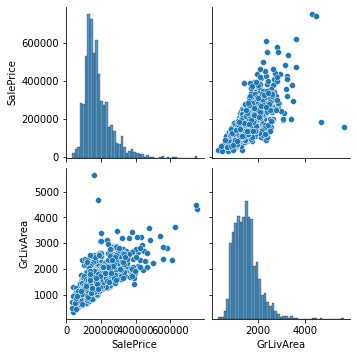

In [6]:
sns.pairplot(train[["SalePrice", 'GrLivArea']])

In [7]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [8]:
train_number = train.shape[0]
test_number = test.shape[0]
full_data = pd.concat((train, test)).reset_index(drop=True)
y = full_data.SalePrice.values
full_data.drop(['SalePrice'], axis=1, inplace=True)
full_data.shape

(2917, 79)

In [9]:
full_data["PoolQC"] = full_data["PoolQC"].fillna("None")
full_data["MiscFeature"] = full_data["MiscFeature"].fillna("None")
full_data["Alley"] = full_data["Alley"].fillna("None")
full_data["Fence"] = full_data["Fence"].fillna("None")
full_data["FireplaceQu"] = full_data["FireplaceQu"].fillna("None")
full_data['MSSubClass'] = full_data['MSSubClass'].fillna("None")
full_data["Functional"] = full_data["Functional"].fillna("Typ")
full_data["MasVnrType"] = full_data["MasVnrType"].fillna("None")
full_data["MasVnrArea"] = full_data["MasVnrArea"].fillna(0)

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    full_data[col] = full_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    full_data[col] = full_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    full_data[col] = full_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full_data[col] = full_data[col].fillna('None')

#LotFrontage: Fill in missing values by the median LotFrontage of the neighborhood.
full_data["LotFrontage"] = full_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


full_data['MSZoning'] = full_data['MSZoning'].fillna(full_data['MSZoning'].mode()[0])
full_data['Electrical'] = full_data['Electrical'].fillna(full_data['Electrical'].mode()[0])
full_data['KitchenQual'] = full_data['KitchenQual'].fillna(full_data['KitchenQual'].mode()[0])
full_data['Exterior1st'] = full_data['Exterior1st'].fillna(full_data['Exterior1st'].mode()[0])
full_data['Exterior2nd'] = full_data['Exterior2nd'].fillna(full_data['Exterior2nd'].mode()[0])
full_data['SaleType'] = full_data['SaleType'].fillna(full_data['SaleType'].mode()[0])

full_data = full_data.drop(['Utilities'], axis=1)

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)
full_data['OverallCond'] = full_data['OverallCond'].astype(str)
full_data['YrSold'] = full_data['YrSold'].astype(str)
full_data['MoSold'] = full_data['MoSold'].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    enc = LabelEncoder() 
    enc.fit(list(full_data[c].values)) 
    full_data[c] = enc.transform(list(full_data[c].values))

In [12]:
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']

In [13]:
full_data = pd.get_dummies(full_data)

In [14]:
full_data.shape

(2917, 220)

In [15]:
test = full_data[train_number:]

In [16]:
test.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1458,5,80.0,11622,1,1,3,0,5,5,1961,...,0,0,0,1,0,0,0,0,1,0
1459,5,81.0,14267,1,1,0,0,6,5,1958,...,0,0,0,1,0,0,0,0,1,0
1460,10,74.0,13830,1,1,0,0,5,4,1997,...,0,0,0,1,0,0,0,0,1,0
1461,10,78.0,9978,1,1,0,0,6,5,1998,...,0,0,0,1,0,0,0,0,1,0
1462,0,43.0,5005,1,1,0,0,8,4,1992,...,0,0,0,1,0,0,0,0,1,0


## Installing Intel(R) Extension for Scikit-learn
Use Intel® Extension for Scikit-learn* for fast compute Scikit-learn estimators.


In [17]:
# !pip install scikit-learn-intelex -q --progress-bar off
# ! pip install optuna

In [18]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(full_data, y, test_size = 0.1, random_state=0)

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = StandardScaler()

scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_val = scaler_x.transform(x_val)
test = scaler_x.transform(test)

scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

In [21]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [22]:
x_train, x_val, y_train, y_val = train_test_split(full_data, y, test_size = 0.1, random_state=0)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = StandardScaler()

scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_val = scaler_x.transform(x_val)
test = scaler_x.transform(test)

scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

## optuna
* ref : https://pypi.org/project/optuna/

## Using optuna to select parameters for nuSVR
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. The advantage of support vector machines is effective in high dimensional spaces.

NuSVR similar to SVR, but uses a parameter nu to control the number of support vectors. Nu replaces the parameter epsilon of epsilon-SVR



Parameters that we select:
* C - Parameter inverse to the regularization coefficient
* nu - An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.

In [23]:
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error
import optuna
def objective_svr(trial):
    params ={
        'C': trial.suggest_float('C', 0.0001, 5.0),
        'nu':  trial.suggest_float('nu', 0.0, 1.0),
    }
    model = NuSVR(**params).fit(x_train, y_train)
    y_pred = model.predict(x_val)
    loss = np.sqrt(mean_squared_error(y_val, y_pred))
    return loss

In [24]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner())

[I 2021-09-23 18:16:24,382] A new study created in memory with name: no-name-1b3a718f-f20b-4e1d-8c59-79efafce9d69


In [ ]:
%%time
study.optimize(objective_svr, n_trials=250)

[I 2021-09-23 18:16:26,454] Trial 0 finished with value: 0.17372426988531403 and parameters: {'C': 3.482376281070749, 'nu': 0.28613933495037946}. Best is trial 0 with value: 0.17372426988531403.
[I 2021-09-23 18:16:28,241] Trial 1 finished with value: 0.18239008088731795 and parameters: {'C': 1.1343345826756592, 'nu': 0.5513147690828912}. Best is trial 0 with value: 0.17372426988531403.
[I 2021-09-23 18:16:30,425] Trial 2 finished with value: 0.16754238734164628 and parameters: {'C': 3.597372902030837, 'nu': 0.42310646012446096}. Best is trial 2 with value: 0.16754238734164628.
[I 2021-09-23 18:16:36,260] Trial 3 finished with value: 0.16778619002598527 and parameters: {'C': 4.903822915503239, 'nu': 0.6848297385848633}. Best is trial 2 with value: 0.16754238734164628.
[I 2021-09-23 18:16:38,186] Trial 4 finished with value: 0.17191385423389668 and parameters: {'C': 2.4047114142316564, 'nu': 0.3921175181941505}. Best is trial 2 with value: 0.16754238734164628.
[I 2021-09-23 18:16:41,246

In [ ]:
%%time
final_model = NuSVR(**study.best_params).fit(full_x, full_y)

In [ ]:
full_x = np.concatenate((x_train, x_val), axis=0)
full_y = np.concatenate((y_train, y_val), axis=0)

In [ ]:
y_pred = final_model.predict(test)
y_pred = scaler_y.inverse_transform(y_pred)

In [ ]:
sample_submission['SalePrice'] = y_pred
sample_submission.to_csv('lkh_opuma.csv', index=False)
sample_submission.head(10)

In [ ]:
### original scikit-learn

In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

from sklearn.svm import NuSVR
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner())





In [ ]:
%%time
study.optimize(objective_svr, n_trials=250)

In [ ]:
%%time
final_model = NuSVR(**study.best_params).fit(full_x, full_y)